# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import ibmos2spark

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max
from pyspark.sql.functions import col
from pyspark.sql.functions import count
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import min
from pyspark.sql.functions import mean
from pyspark.sql.functions import countDistinct
#from pyspark.sql.functions import *
from pyspark.sql import Window

from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, NaiveBayes, RandomForestClassifier, OneVsRest
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

from functools import reduce

import pandas as pd

import numpy as np

import datetime

import seaborn as sb

import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200425074503-0001
KERNEL_ID = 27a1f723-edec-4b64-9532-665e5c0e1f63


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
spark.conf.get("spark.sql.shuffle.partitions")

'200'

In [4]:
spark.conf.set("spark.sql.shuffle.partitions", 5)

In [5]:
spark.conf.get("spark.sql.shuffle.partitions")

'5'

In [6]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-cv12zd88h5hv46'))

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.count()

543705

In [9]:
df.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [10]:
df.toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246
5,Carter USM,Logged In,Sofia,F,266,Gordon,138.29179,paid,"Rochester, MN",PUT,NextSong,1.533176e+12,162,Airplane Food,200,1538352125000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",163
6,None,Logged Out,None,None,186,None,NaN,paid,None,GET,Home,NaN,178,None,200,1538352148000,None,
7,None,Logged Out,None,None,187,None,NaN,paid,None,GET,Home,NaN,178,None,200,1538352151000,None,
8,None,Logged Out,None,None,188,None,NaN,paid,None,GET,Home,NaN,178,None,200,1538352168000,None,
9,None,Logged Out,None,None,189,None,NaN,paid,None,PUT,Login,NaN,178,None,307,1538352169000,None,


In [11]:
df.toPandas().isnull().sum()

artist           110828
auth                  0
firstName         15700
gender            15700
itemInSession         0
lastName          15700
length           110828
level                 0
location          15700
method                0
page                  0
registration      15700
sessionId             0
song             110828
status                0
ts                    0
userAgent         15700
userId                0
dtype: int64

It seems that we have two pairs of columns that have an dependence.

Pair one (110828): artist, length, song
I would expect that in this case no song was played and some other pages like help were opened

Pair two (15700): firstName, gender, lastName, location, registered, userAgent
This could be visit without an active logged in user.

In [12]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_valid.count()

543705

In [13]:
df_valid = df_valid.filter(df_valid.userId!="")
df_valid.count()

528005

In [14]:
df_valid.select('location').dropDuplicates().sort('location').show()

+--------------------+
|            location|
+--------------------+
|           Akron, OH|
|          Albany, OR|
|Albany-Schenectad...|
|       Albemarle, NC|
|      Alexandria, LA|
|      Alexandria, MN|
|Allentown-Bethleh...|
|       Anchorage, AK|
|        Appleton, WI|
|          Athens, TX|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|          Auburn, IN|
|Augusta-Watervill...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|Beaumont-Port Art...|
|      Big Spring, TX|
|        Billings, MT|
+--------------------+
only showing top 20 rows



In [15]:
df_valid.select('userAgent').dropDuplicates().sort('userAgent').show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 20 rows



In [16]:
df_valid.select('auth').dropDuplicates().sort('auth').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [17]:
df_valid.select('page').dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [18]:
df_valid.select('userId').dropDuplicates().count()

448

In [19]:
#df_valid.select(["userId", "firstname", "page", "song"]).where(df.userId == "293").collect()

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### Cancellation Confirmation

In [20]:
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [21]:
df_valid = df_valid.withColumn("churn", flag_cancellation_event("page"))

In [22]:
df_valid.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', churn=0)

In [23]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [24]:
df_valid = df_valid.withColumn("churn", Fsum("churn").over(windowval))

In [25]:
#df_valid.select(["userId", "firstname", "ts", "itemInSession", "sessionId", "page", "level", "churn"]).where(df_valid.userId == "32").sort("ts").collect()

#### Downgrade Events

In [26]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [27]:
df_valid = df_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [28]:
df_valid.head()

Row(artist=None, auth='Cancelled', firstName='Brycen', gender='M', itemInSession=435, lastName='Bradley', length=None, level='paid', location='Laurel, MS', method='GET', page='Cancellation Confirmation', registration=1538159495000, sessionId=9, song=None, status=200, ts=1539055364000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', churn=1, downgraded=0)

With this function we can split the events in before and after downgrade and find multiple downgrades for the same user.

In [29]:
df_valid = df_valid.withColumn("phase_down", Fsum("downgraded").over(windowval))

In [30]:
#df_valid.select(["userId", "firstname", "ts", "page", "level", "phase_down", "downgraded"]).where(df_valid.userId == "11").sort("ts").collect()

Updating df_p with the new columns for exploration

In [31]:
#df_p = df_valid.toPandas()

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [32]:
df_valid.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  349|
|    1|   99|
+-----+-----+



In [33]:
df_valid.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| free|   82|
|    0| paid|  246|
|    1| paid|   75|
|    0| free|  288|
+-----+-----+-----+



In [34]:
df_valid.select('status').dropDuplicates().sort('status').show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



Meaning of status codes:
- 200 OK
- 307 Temporary Redirect
- 404 Not Found

In [35]:
df_valid.groupby(['churn', 'status']).count().sort(['churn', 'status']).show()

+-----+------+------+
|churn|status| count|
+-----+------+------+
|    0|   200|388530|
|    0|   307| 35423|
|    0|   404|   406|
|    1|   200| 95070|
|    1|   307|  8479|
|    1|   404|    97|
+-----+------+------+



In [36]:
df_valid.groupby(['phase_down', 'status']).count().sort(['phase_down', 'status']).show()

+----------+------+------+
|phase_down|status| count|
+----------+------+------+
|         0|   200|371172|
|         0|   307| 33664|
|         0|   404|   373|
|         1|   200| 98480|
|         1|   307|  8936|
|         1|   404|   110|
|         2|   200| 12815|
|         2|   307|  1150|
|         2|   404|    19|
|         3|   200|  1133|
|         3|   307|   152|
|         3|   404|     1|
+----------+------+------+



In [37]:
df_valid.select(["userId", "firstname", "ts", "page", "level", "churn", "phase_down"]).where(df_valid.status == "404").sort("ts").count()

503

### Calculating by Hour

In [38]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [39]:
df_valid = df_valid.withColumn("hour", get_hour(df_valid.ts))

In [40]:
df_valid.head()

Row(artist=None, auth='Cancelled', firstName='Brycen', gender='M', itemInSession=435, lastName='Bradley', length=None, level='paid', location='Laurel, MS', method='GET', page='Cancellation Confirmation', registration=1538159495000, sessionId=9, song=None, status=200, ts=1539055364000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', churn=1, downgraded=0, phase_down=0, hour='3')

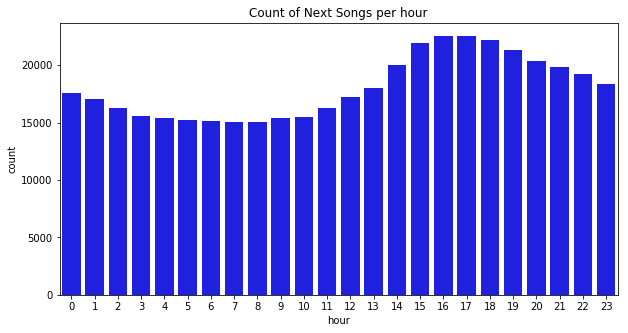

In [41]:
df_help = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.hour).count().orderBy(df_valid.hour.cast("float"))
pd_help = df_help.toPandas()
pd_help.hour = pd.to_numeric(pd_help.hour)

plt.figure(figsize = [10,5])
sb.barplot(data=pd_help, x='hour', y='count', color='blue').set_title('Count of Next Songs per hour');

### Calculating by Weekday

In [42]:
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [43]:
df_valid = df_valid.withColumn("weekday", get_weekday(df_valid.ts))

In [44]:
df_help = df_valid.filter(df_valid.page == "NextSong").groupby(df_valid.weekday).count().orderBy(df_valid.weekday.cast("int"))

In [45]:
pd_help = df_help.toPandas()
pd_help.weekday = pd.to_numeric(pd_help.weekday)

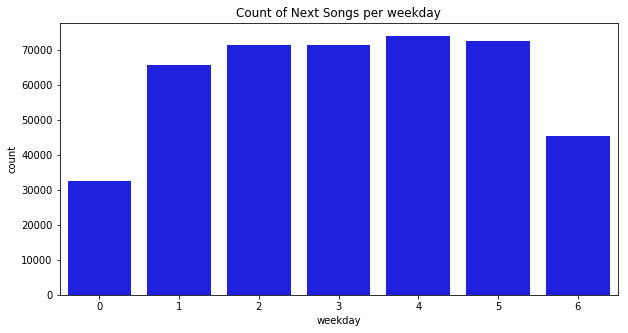

In [46]:
plt.figure(figsize = [10,5])
sb.barplot(data=pd_help, x='weekday', y='count', color='blue').set_title('Count of Next Songs per weekday');

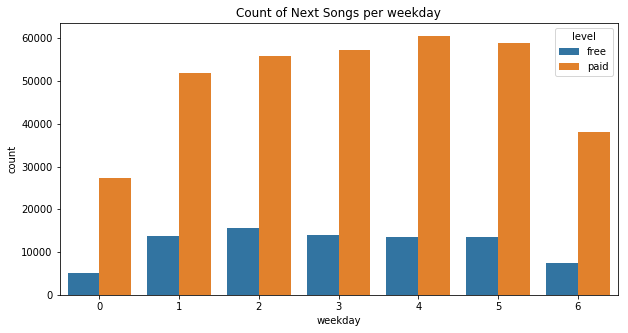

In [47]:
df_help = df_valid.filter(df_valid.page == "NextSong").groupby([df_valid.weekday, df_valid.level]).count().orderBy(df_valid.weekday.cast("int"))
pd_help = df_help.toPandas()
pd_help.weekday = pd.to_numeric(pd_help.weekday)
plt.figure(figsize = [10,5])
sb.barplot(data=pd_help, x='weekday', y='count', hue='level').set_title('Count of Next Songs per weekday');

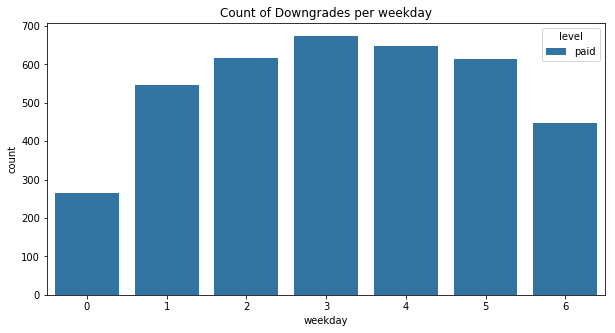

In [48]:
df_help = df_valid.filter(df_valid.page == "Downgrade").groupby([df_valid.weekday, df_valid.level]).count().orderBy(df_valid.weekday.cast("int"))
pd_help = df_help.toPandas()
pd_help.weekday = pd.to_numeric(pd_help.weekday)
plt.figure(figsize = [10,5])
sb.barplot(data=pd_help, x='weekday', y='count', hue='level').set_title('Count of Downgrades per weekday');

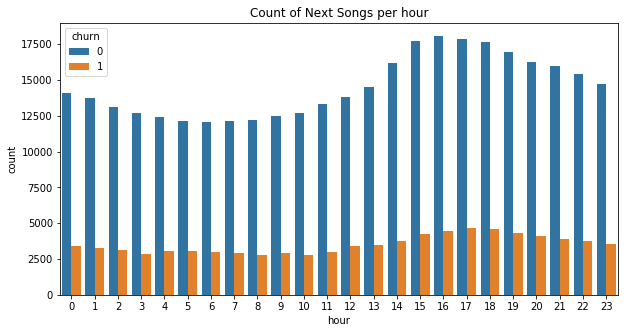

In [49]:
df_help = df_valid.filter(df_valid.page == "NextSong").groupby([df_valid.hour, df_valid.churn]).count().orderBy(df_valid.hour.cast("int"))
pd_help = df_help.toPandas()
pd_help.hour = pd.to_numeric(pd_help.hour)
plt.figure(figsize = [10,5])
sb.barplot(data=pd_help, x='hour', y='count', hue='churn').set_title('Count of Next Songs per hour');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Feature 1: Unique User, gender, registration, churn and number of actions

In [50]:
df_features = 0
df_features = df_valid.groupby(['userId', 'gender', 'registration','churn']).agg(count('userID').alias('num_actions'))

In [51]:
df_features = df_features.withColumn('gender', regexp_replace('gender', 'F', '0'))
df_features = df_features.withColumn('gender', regexp_replace('gender', 'M', '1'))

In [52]:
df_features.show()

+------+------+-------------+-----+-----------+
|userId|gender| registration|churn|num_actions|
+------+------+-------------+-----+-----------+
|    10|     1|1538159495000|    1|        423|
|100003|     0|1537309344000|    1|        827|
|100005|     1|1532610926000|    1|        100|
|100010|     0|1538016340000|    1|        137|
|100024|     1|1536343087000|    1|       1084|
|100033|     0|1534805438000|    0|        819|
|100046|     0|1534418833000|    0|        639|
|100049|     1|1534537891000|    1|        603|
|   105|     1|1536817381000|    0|       3597|
|   107|     0|1536303841000|    0|        779|
|   108|     0|1538215963000|    0|        196|
|   110|     1|1537665002000|    0|        525|
|   112|     1|1536032681000|    0|        411|
|   117|     0|1537142824000|    0|        258|
|   118|     0|1537893493000|    1|       2623|
|    12|     0|1533885783000|    0|       4232|
|    13|     0|1533192032000|    1|        586|
|   137|     1|1532450666000|    0|     

In [53]:
df_features.count()

448

### Feature 2: Days since registration and last action

In [54]:
days_registered_df = df_valid.groupBy('userId').agg(max('ts').alias('last_interaction'))
df_features = days_registered_df.join(df_features, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))

### Feature 3: Page Visits

In [55]:
df_for_list = df_valid.select('page').dropDuplicates().sort('page').toPandas()
page_list = df_for_list.page.tolist()

page_list.remove('Cancel')
page_list.remove('Cancellation Confirmation')

page_list

['About',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

In [56]:
def add_page_count(page_list, df_features):
    
    for page in page_list:
        page_name = page.replace(' ', '_')
        count_df = df_valid.filter(df_valid.page == page).groupby('userID').agg(count('page').alias("count_" + page_name))
        df_features = count_df.join(df_features, on='userId', how='right')
        print(page + " done.. " + str(count_df.count()) + " unique users found..")
    
    df_features = df_features.na.fill(0)
    return df_features
        

In [57]:
df_features = add_page_count(page_list, df_features)

About done.. 291 unique users found..
Add Friend done.. 409 unique users found..
Add to Playlist done.. 428 unique users found..
Downgrade done.. 301 unique users found..
Error done.. 223 unique users found..
Help done.. 360 unique users found..
Home done.. 440 unique users found..
Logout done.. 426 unique users found..
NextSong done.. 448 unique users found..
Roll Advert done.. 395 unique users found..
Save Settings done.. 242 unique users found..
Settings done.. 379 unique users found..
Submit Downgrade done.. 97 unique users found..
Submit Upgrade done.. 233 unique users found..
Thumbs Down done.. 389 unique users found..
Thumbs Up done.. 439 unique users found..
Upgrade done.. 315 unique users found..


### Feature 4: Number of downgrades

In [58]:
num_down_df = df_valid.groupBy('userId').agg(count('downgraded').alias('num_downgrades'))
df_features = num_down_df.join(df_features, on='userId', how='right')

### Feature 5: 404 Error

In [59]:
count_404_df = df_valid.filter(df_valid.status == "404").groupby('userID').agg(count('status').alias('count_404'))
df_features = count_404_df.join(df_features, on='userId', how='right')

### Feature 6: Sum and Avg Days paid used


In [60]:
avg_days_paid_df = df_valid.filter(df_valid.level == "paid").groupby([df_valid.userId, df_valid.phase_down]).agg(min('ts').alias('first_interaction'), max('ts').alias('last_interaction'))
df_with = avg_days_paid_df.withColumn('days_paid', ((col('last_interaction')-col('first_interaction'))/86400000))
df_clean = df_with.groupby('userId').agg(mean('days_paid').alias('avg_days_paid'))
df_features = df_clean.join(df_features, on='userId', how='right')

In [61]:
df_clean = df_with.groupby('userId').agg(Fsum('days_paid').alias('sum_days_paid'))
df_features = df_clean.join(df_features, on='userId', how='right')

### Feature 7: Sum and Avg Days free used

In [62]:
avg_days_paid_df = df_valid.filter(df_valid.level == "free").groupby([df_valid.userId, df_valid.phase_down]).agg(min('ts').alias('first_interaction'), max('ts').alias('last_interaction'))
df_with = avg_days_paid_df.withColumn('days_free', ((col('last_interaction')-col('first_interaction'))/86400000))
df_clean = df_with.groupby('userId').agg(mean('days_free').alias('avg_days_free'))
df_features = df_clean.join(df_features, on='userId', how='right')

In [63]:
df_clean = df_with.groupby('userId').agg(Fsum('days_free').alias('sum_days_free'))
df_features = df_clean.join(df_features, on='userId', how='right')

### Feature 8: Sum and Avg session duration


In [64]:
avg_session_df = df_valid.groupBy(['userId', 'sessionId']).agg(min('ts').alias('first_interaction'), max('ts').alias('last_interaction'))
df_with = avg_session_df.withColumn('session_min', ((col('last_interaction')-col('first_interaction'))/1440000).cast(IntegerType()))
df_clean = df_with.groupby('userId').agg(mean('session_min').alias('avg_session_min'))
df_features = df_clean.join(df_features, on='userId', how='right')

In [65]:
df_clean = df_with.groupby('userId').agg(Fsum('session_min').alias('sum_session_min'))
df_features = df_clean.join(df_features, on='userId', how='right')

### Feature 9: Sum and Avg songs per Session

In [66]:
songs_session_df = df_valid.filter(df_valid.page == "NextSong").groupby(['userID', 'sessionId']).agg(count('page').alias('songs_session'))
df_clean = songs_session_df.groupby('userId').agg(mean('songs_session').alias('avg_songs_session'))
df_features = df_clean.join(df_features, on='userId', how='right')

In [67]:
df_clean = songs_session_df.groupby('userId').agg(Fsum('songs_session').alias('sum_songs'))
df_features = df_clean.join(df_features, on='userId', how='right')

### Feature 10: Avg actions per Session
itemINSession start with 0. So we need to add +1

In [68]:
actions_df = df_valid.groupBy(['userId', 'sessionId']).agg((max('itemINSession')+1).alias('actions_session'))
df_clean = actions_df.groupby('userId').agg(mean('actions_session').alias('avg_actions_session'))
df_features = df_clean.join(df_features, on='userId', how='right')

### Feature 11: Number of Sessions

In [69]:
num_session_df = df_valid.groupby(['userID']).agg(countDistinct('sessionId').alias('num_session'))
df_features = num_session_df.join(df_features, on='userId', how='right')

### Final Steps

In [70]:
df_features = df_features.na.fill(0)

In [71]:
df_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_session: long (nullable = true)
 |-- avg_actions_session: double (nullable = false)
 |-- sum_songs: long (nullable = true)
 |-- avg_songs_session: double (nullable = false)
 |-- sum_session_min: long (nullable = true)
 |-- avg_session_min: double (nullable = false)
 |-- sum_days_free: double (nullable = false)
 |-- avg_days_free: double (nullable = false)
 |-- sum_days_paid: double (nullable = false)
 |-- avg_days_paid: double (nullable = false)
 |-- count_404: long (nullable = true)
 |-- num_downgrades: long (nullable = true)
 |-- count_Upgrade: long (nullable = true)
 |-- count_Thumbs_Up: long (nullable = true)
 |-- count_Thumbs_Down: long (nullable = true)
 |-- count_Submit_Upgrade: long (nullable = true)
 |-- count_Submit_Downgrade: long (nullable = true)
 |-- count_Settings: long (nullable = true)
 |-- count_Save_Settings: long (nullable = true)
 |-- count_Roll_Advert: long (nullable = true)
 |-- count_NextSong: long (nullable = 

In [72]:
pd_final = df_features.toPandas()

In [73]:
pd.set_option('display.max_columns', 40)
pd_final.head()

,userId,num_session,avg_actions_session,sum_songs,avg_songs_session,sum_session_min,avg_session_min,sum_days_free,avg_days_free,sum_days_paid,avg_days_paid,count_404,num_downgrades,count_Upgrade,count_Thumbs_Up,count_Thumbs_Down,count_Submit_Upgrade,count_Submit_Downgrade,count_Settings,count_Save_Settings,count_Roll_Advert,count_NextSong,count_Logout,count_Home,count_Help,count_Error,count_Downgrade,count_Add_to_Playlist,count_Add_Friend,count_About,last_interaction,gender,registration,churn,num_actions,registered_days
0,10,1,436.000000,360,360.000000,62,62.000000,0.000000,0.000000,1.043333,1.043333,1,423,0,17,1,0,0,2,0,0,360,4,15,3,1,1,14,3,0,1539055364000,1,1538159495000,1,423,10
1,100003,9,95.333333,661,82.625000,107,11.888889,18.268137,18.268137,11.374826,11.374826,1,827,2,16,10,1,0,4,1,41,661,12,31,3,1,13,19,8,2,1541661592000,0,1537309344000,1,827,50
2,100005,2,51.000000,72,36.000000,11,5.500000,4.787778,4.787778,0.000000,0.000000,0,100,1,2,1,0,0,0,0,17,72,1,3,0,0,0,1,0,0,1538820679000,1,1532610926000,1,100,71
3,100010,2,69.500000,96,48.000000,17,8.500000,3.043125,3.043125,0.000000,0.000000,0,137,2,4,3,0,0,0,0,22,96,1,3,0,0,0,1,3,0,1539254318000,0,1538016340000,1,137,14
4,100024,13,85.153846,883,67.923077,141,10.846154,15.357731,7.678866,27.098148,13.549074,1,1084,2,46,10,2,1,6,3,32,883,10,38,2,1,10,25,10,1,1542147643000,1,1536343087000,1,1084,67


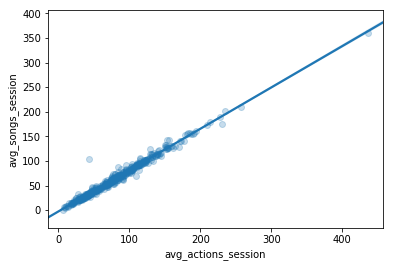

In [74]:
sb.regplot(data = pd_final, x = 'avg_actions_session', y = 'avg_songs_session', scatter_kws ={'alpha' : 1/4})

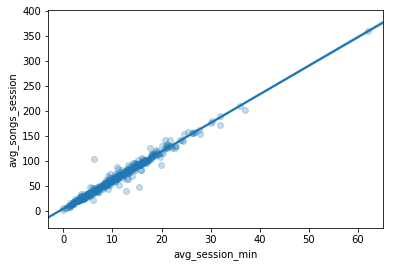

In [75]:
sb.regplot(data = pd_final, x = 'avg_session_min', y = 'avg_songs_session',scatter_kws ={'alpha' : 1/4})

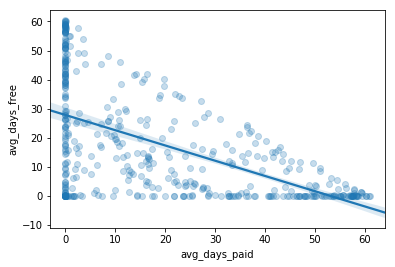

In [76]:
sb.regplot(data = pd_final, x = 'avg_days_paid', y = 'avg_days_free',scatter_kws ={'alpha' : 1/4})

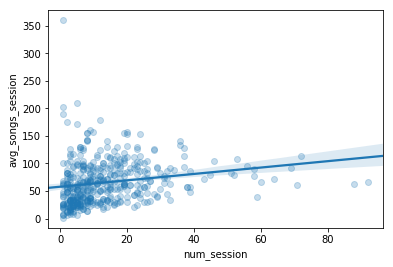

In [77]:
sb.regplot(data = pd_final, x = 'num_session', y = 'avg_songs_session', scatter_kws ={'alpha' : 1/4})

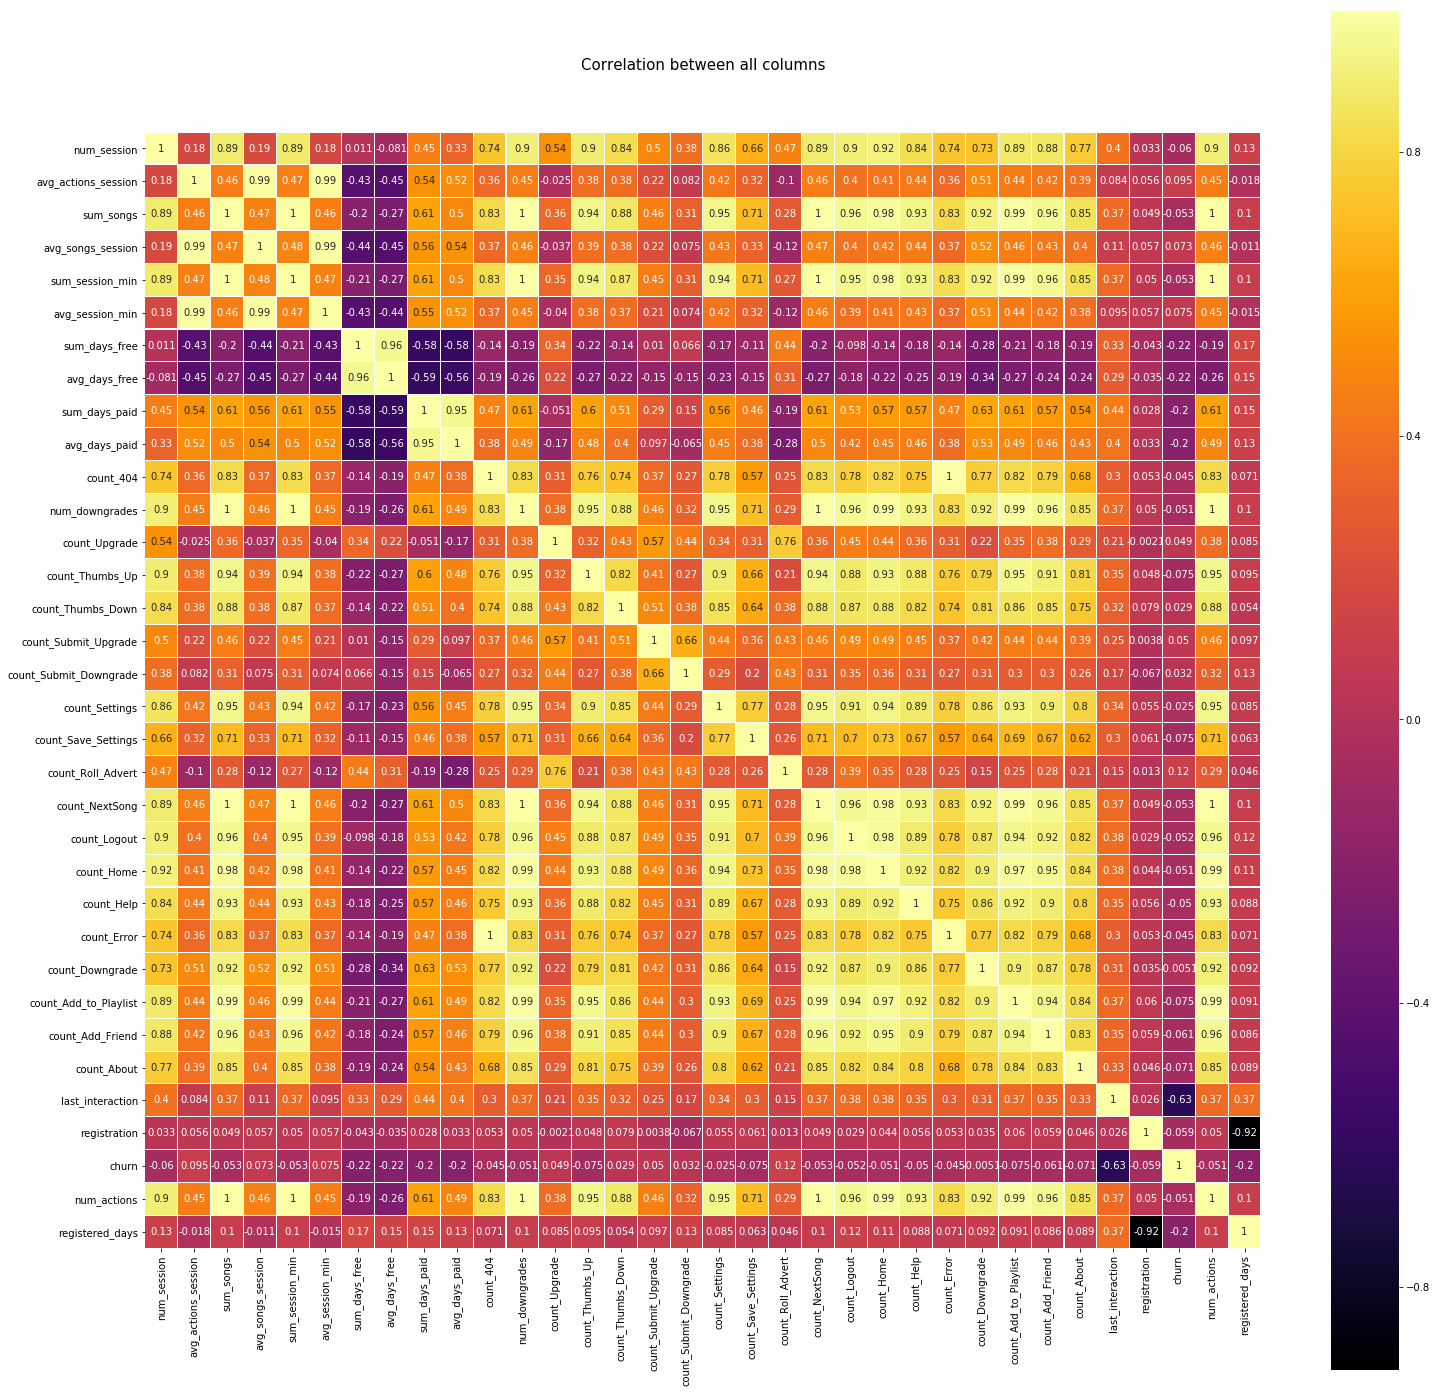

In [78]:
plt.figure(figsize=(25,25))
plt.title('Correlation between all columns', y=1.05, size=15)
sb.heatmap(pd_final.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.inferno, linecolor='white', annot=True)

In [80]:
df_work = df_features

In [81]:
df.unpersist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [82]:
df_features.unpersist()

DataFrame[userId: string, num_session: bigint, avg_actions_session: double, sum_songs: bigint, avg_songs_session: double, sum_session_min: bigint, avg_session_min: double, sum_days_free: double, avg_days_free: double, sum_days_paid: double, avg_days_paid: double, count_404: bigint, num_downgrades: bigint, count_Upgrade: bigint, count_Thumbs_Up: bigint, count_Thumbs_Down: bigint, count_Submit_Upgrade: bigint, count_Submit_Downgrade: bigint, count_Settings: bigint, count_Save_Settings: bigint, count_Roll_Advert: bigint, count_NextSong: bigint, count_Logout: bigint, count_Home: bigint, count_Help: bigint, count_Error: bigint, count_Downgrade: bigint, count_Add_to_Playlist: bigint, count_Add_Friend: bigint, count_About: bigint, last_interaction: bigint, gender: string, registration: bigint, churn: bigint, num_actions: bigint, registered_days: int]

In [83]:
df_valid.unpersist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: bigint, downgraded: int, phase_down: bigint, hour: string, weekday: string]

In [84]:
df_help.unpersist()

DataFrame[hour: string, churn: bigint, count: bigint]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [86]:
col_int = ['num_session', 'sum_songs', 'sum_session_min', 'count_404', 'num_downgrades', 'count_Upgrade', 'count_Thumbs_Up', 'count_Thumbs_Down', 'count_Submit_Upgrade', 'count_Submit_Downgrade', 'count_Settings', 'count_Save_Settings', 'count_Roll_Advert', 'count_NextSong', 'count_Logout', 'count_Home', 'count_Help', 'count_Error', 'count_Downgrade', 'count_Add_to_Playlist', 'count_Add_Friend', 'count_About', 'gender',  'churn', 'num_actions', 'registered_days']
col_float = ['avg_actions_session', 'avg_songs_session', 'avg_session_min', 'sum_days_free', 'avg_days_free', 'sum_days_paid', 'avg_days_paid']
col_long = ['registration', 'last_interaction']

In [87]:
for column in col_int:
    df_work = df_work.withColumn(column, df_work[column].cast(IntegerType()))
    
for column in col_float:
    df_work = df_work.withColumn(column, df_work[column].cast('float'))

for column in col_long:
    df_work = df_work.withColumn(column, df_work[column].cast('long')) 

In [88]:
df_work.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_session: integer (nullable = true)
 |-- avg_actions_session: float (nullable = false)
 |-- sum_songs: integer (nullable = true)
 |-- avg_songs_session: float (nullable = false)
 |-- sum_session_min: integer (nullable = true)
 |-- avg_session_min: float (nullable = false)
 |-- sum_days_free: float (nullable = false)
 |-- avg_days_free: float (nullable = false)
 |-- sum_days_paid: float (nullable = false)
 |-- avg_days_paid: float (nullable = false)
 |-- count_404: integer (nullable = true)
 |-- num_downgrades: integer (nullable = true)
 |-- count_Upgrade: integer (nullable = true)
 |-- count_Thumbs_Up: integer (nullable = true)
 |-- count_Thumbs_Down: integer (nullable = true)
 |-- count_Submit_Upgrade: integer (nullable = true)
 |-- count_Submit_Downgrade: integer (nullable = true)
 |-- count_Settings: integer (nullable = true)
 |-- count_Save_Settings: integer (nullable = true)
 |-- count_Roll_Advert: integer (nullable = true)
 |-- c

In [89]:
df_work.take(1)

[Row(userId='10', num_session=1, avg_actions_session=436.0, sum_songs=360, avg_songs_session=360.0, sum_session_min=62, avg_session_min=62.0, sum_days_free=0.0, avg_days_free=0.0, sum_days_paid=1.0433332920074463, avg_days_paid=1.0433332920074463, count_404=1, num_downgrades=423, count_Upgrade=0, count_Thumbs_Up=17, count_Thumbs_Down=1, count_Submit_Upgrade=0, count_Submit_Downgrade=0, count_Settings=2, count_Save_Settings=0, count_Roll_Advert=0, count_NextSong=360, count_Logout=4, count_Home=15, count_Help=3, count_Error=1, count_Downgrade=1, count_Add_to_Playlist=14, count_Add_Friend=3, count_About=0, last_interaction=1539055364000, gender=1, registration=1538159495000, churn=1, num_actions=423, registered_days=10)]

In [90]:
#It seems the model overfits for the last_interaction and registration column so I will not add them

cols = col_int + col_float
cols.remove('churn')

cols

['num_session',
 'sum_songs',
 'sum_session_min',
 'count_404',
 'num_downgrades',
 'count_Upgrade',
 'count_Thumbs_Up',
 'count_Thumbs_Down',
 'count_Submit_Upgrade',
 'count_Submit_Downgrade',
 'count_Settings',
 'count_Save_Settings',
 'count_Roll_Advert',
 'count_NextSong',
 'count_Logout',
 'count_Home',
 'count_Help',
 'count_Error',
 'count_Downgrade',
 'count_Add_to_Playlist',
 'count_Add_Friend',
 'count_About',
 'gender',
 'num_actions',
 'registered_days',
 'avg_actions_session',
 'avg_songs_session',
 'avg_session_min',
 'sum_days_free',
 'avg_days_free',
 'sum_days_paid',
 'avg_days_paid']

### VectorAssembler

In [91]:
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
df_vector = assembler.transform(df_work)

### Normalize the Vectors

In [92]:
#scaler = Normalizer(inputCol="NumFeatures", outputCol="ScaledFeatures")
#df_norm = scaler.transform(df_vector)

### Scale the Vectors

In [93]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="ScaledFeatures2", withStd=True)
scalerModel = scaler2.fit(df_vector)
df_scaled = scalerModel.transform(df_vector)

In [94]:
df_ml = df_scaled.select(df_scaled.churn.alias('label'), df_scaled.ScaledFeatures2.alias('features'))

In [95]:
df_vector.unpersist()
df_scaled.unpersist()

DataFrame[userId: string, num_session: int, avg_actions_session: float, sum_songs: int, avg_songs_session: float, sum_session_min: int, avg_session_min: float, sum_days_free: float, avg_days_free: float, sum_days_paid: float, avg_days_paid: float, count_404: int, num_downgrades: int, count_Upgrade: int, count_Thumbs_Up: int, count_Thumbs_Down: int, count_Submit_Upgrade: int, count_Submit_Downgrade: int, count_Settings: int, count_Save_Settings: int, count_Roll_Advert: int, count_NextSong: int, count_Logout: int, count_Home: int, count_Help: int, count_Error: int, count_Downgrade: int, count_Add_to_Playlist: int, count_Add_Friend: int, count_About: int, last_interaction: bigint, gender: int, registration: bigint, churn: int, num_actions: int, registered_days: int, NumFeatures: vector, ScaledFeatures2: vector]

In [96]:
df_ml.persist()

DataFrame[label: int, features: vector]

In [97]:
df_ml.take(2)

[Row(label=1, features=DenseVector([0.0759, 0.3128, 0.3195, 0.5946, 0.3064, 0.0, 0.2441, 0.0749, 0.0, 0.0, 0.2534, 0.0, 0.0, 0.3128, 0.2743, 0.3235, 0.4102, 0.5946, 0.0843, 0.4157, 0.1351, 0.0, 2.0114, 0.3064, 0.2467, 9.3487, 9.1151, 9.0648, 0.0, 0.0, 0.0485, 0.051])),
 Row(label=1, features=DenseVector([0.6833, 0.5744, 0.5514, 0.5946, 0.599, 0.7868, 0.2297, 0.7487, 1.4091, 0.0, 0.5067, 0.5539, 1.9158, 0.5744, 0.823, 0.6686, 0.4102, 0.5946, 1.0961, 0.5642, 0.3603, 0.6346, 0.0, 0.599, 1.2336, 2.0441, 2.092, 1.7382, 0.9282, 0.9605, 0.5291, 0.5558]))]

In [98]:
train, test = df_ml.randomSplit([0.8, 0.2], seed=123)
#CrossVaolidator will split the train set in train/validation to find the best params
#test, validation = rest.randomSplit([0.5, 0.5], seed=123)

train.persist()
test.persist()

print('train size: ' + str(train.count()))
print('test size: ' + str(test.count()))
#print('validation size: ' + str(validation.count()))

train size: 355
test size: 93


In [99]:
train.groupby(['label']).count().show()
test.groupby(['label']).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  276|
|    1|   79|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|   73|
|    1|   20|
+-----+-----+



In [100]:
df_ml.unpersist()

DataFrame[label: int, features: vector]

In [101]:
pd_final = []

### Definition of functions

In [134]:
def model_eval(model, test_data, df=False, duration=0):
    
    predictions = model.transform(test_data)\
    .select("features", "label", "prediction")

    predictions = predictions.select(col("label").cast("Float"),col("prediction"))
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluatorf1.evaluate(predictions)
    
    evaluatorwp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    wp = evaluatorwp.evaluate(predictions)
    
    evaluatorwr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    wr = evaluatorwr.evaluate(predictions)
    
    if df:
        results = {}
        results['test_error'] = 1.0 - accuracy
        results['accuracy'] = accuracy
        results['f1'] = f1
        results['weightedPrecision'] = wp
        results['weightedRecal'] = wr
        results['duration'] = duration
        print("Test Error = %g" % (1.0 - accuracy))
        print("Accuracy = %g" % accuracy)
        print("f1 = %g" % f1)
        print(predictions.crosstab('label','prediction').show())
        return results
    else: 
        print("Test Error = %g" % (1.0 - accuracy))
        print("Accuracy = %g" % accuracy)
        print("f1 = %g" % f1)
        print("weightedPrecision = %g" % wp)
        print("weightedRecall = %g" % wr)
        print(predictions.crosstab('label','prediction').show())
    

In [103]:
def fit_and_eval(model_list, train, test):
    results = {}
    for model in model_list:
        
        print('Training model: ' + model)
        start_time = time.time()
        model_type = eval(model)
        model_fitted = model_type.fit(train)
        end_time = time.time()
        duration = end_time-start_time
        a = datetime.timedelta(seconds=int(duration))
        print("Done in: {}".format(str(a)))
        print("")
        results[model] = model_eval(model_fitted, test, True, duration)
        print("")
    return results

In [129]:
def evaluate(results):
    """
    Visualization code to display results of max 9 various learners.
    
    inputs:
      - results: a list of supervised learners (as keys) with following columns
          - test_error: The score for the naive predictor
          - accuracy: The score for the naive predictor
          - f1: The score for the naive predictor
          - weightedPrecision: The score for the naive predictor
          - weightedRecal: The score for the naive predictor
          - duration: Time for fitting
    """
  
    # Create figure
    fig, ax = plt.subplots(3, 2, figsize = (13,15))

    # Constants
    bar_width = 0.3
    colors = ['#7293CB','#E1974C','#84BA5B','#D35E60','#808585','#9067A7','#AB6857','#CCC210','#00A000']
    colors_line = ['#396AB1', '#DA7C30', '#3E9651', '#CC2529', '#535154', '#6B4C9A', '#922428', '#948B3D']
    
    # Super loop to plot panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['test_error', 'accuracy', 'f1', 'weightedPrecision', 'weightedRecal', 'duration']):

            for i in np.arange(1):
                # Creative plot code
                ax[j//2, j%2].bar(i+k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
                ax[j//2, j%2].set_xticks([])
                ax[j//2, j%2].set_xticklabels([""])
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Error")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[1, 0].set_ylabel("F-score")
    ax[1, 1].set_ylabel("Weighted Precision")
    ax[2, 0].set_ylabel("Weighted Recal")
    ax[2, 1].set_ylabel("Time (in seconds)")
    
    # Add titles
    ax[0, 0].set_title("Error")
    ax[0, 1].set_title("Accuracy Score")
    ax[1, 0].set_title("F-score")
    ax[1, 1].set_title("Weighted Precision")
    ax[2, 0].set_title("Weighted Recal")
    ax[2, 1].set_title("Duration")
    
    # Set y-limits for score panels
    ax[0, 0].set_ylim((0, 1))
    ax[0, 1].set_ylim((0, 1))
    ax[1, 0].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[2, 0].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (0, 3.90), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [105]:
def feature_plot(li_importances, li_column):
    
    
    # Display the ten most important features
    indices = np.argsort(pd.Series(li_importances))[::-1]
    columns = pd.Series(li_column).values[indices[:10]]
    values = pd.Series(li_importances)[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (12,5))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#7293CB', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#E1974C', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.xticks(rotation=60);
    plt.show()  

In [136]:
model_list = []
model_list.append('LogisticRegression()')
model_list.append('RandomForestClassifier()')
model_list.append('GBTClassifier(maxIter=10)')
model_list.append('LinearSVC(maxIter=10, regParam=0.1)')
model_list.append('DecisionTreeClassifier()')
model_list.append('NaiveBayes()')
lr = LogisticRegression()
model_list.append('OneVsRest(classifier=lr)')

In [137]:
results = fit_and_eval(model_list, train, test)

Training model: LogisticRegression()
Done in: 0:00:14

Test Error = 0.139785
Accuracy = 0.860215
f1 = 0.858898
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  7| 13|
|             0.0| 67|  6|
+----------------+---+---+

None

Training model: RandomForestClassifier()
Done in: 0:00:01

Test Error = 0.182796
Accuracy = 0.817204
f1 = 0.78894
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 14|  6|
|             0.0| 70|  3|
+----------------+---+---+

None

Training model: GBTClassifier(maxIter=10)
Done in: 0:00:12

Test Error = 0.16129
Accuracy = 0.83871
f1 = 0.846659
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  4| 16|
|             0.0| 62| 11|
+----------------+---+---+

None

Training model: LinearSVC(maxIter=10, regParam=0.1)
Done in: 0:00:03

Test Error = 0.215054
Accuracy = 0.784946
f1 = 0.690374
+----------------+---+
|labe

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


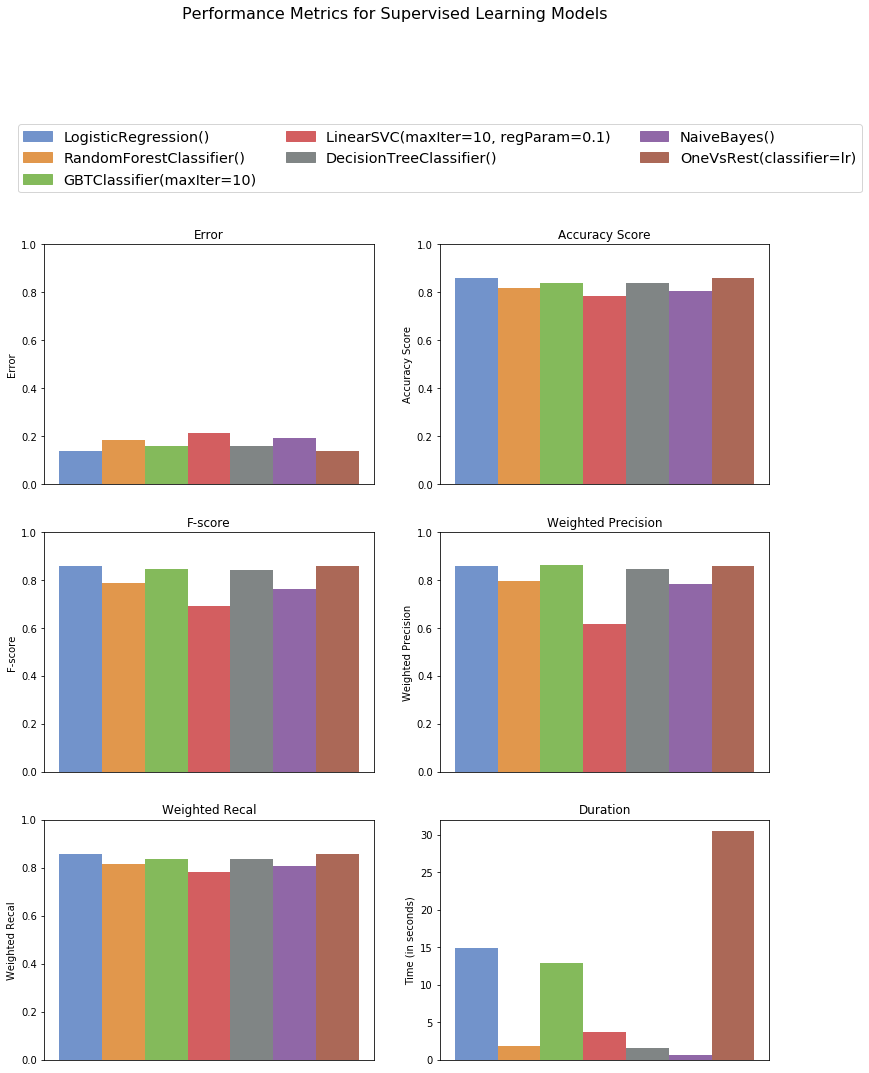

In [138]:
evaluate(results)

## Tuning LogisticRegression

In [109]:
model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()

model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=42, parallelism=10)

start_time = time.time()
print('Start fitting..')
fitted_model = model_evaluator.fit(train)
duration = time.time()-start_time
print(f'Done in {str(datetime.timedelta(seconds=int(duration)))}')
bestModel = fitted_model.bestModel
print('Details:')
print('regParam - ', bestModel.getOrDefault('regParam'))
print('elasticNetParam - ', bestModel.getOrDefault('elasticNetParam'))
print('aggregationDepth - ', bestModel.getOrDefault('aggregationDepth'))

Start fitting..
Done in 0:03:19
Details:
regParam -  0.01
elasticNetParam -  0.0
aggregationDepth -  2


In [112]:
model_eval(fitted_model, train)

Test Error = 0.166197
Accuracy = 0.833803
f1 = 0.820551
weightedPrecision = 0.821194
weightedRecall = 0.833803
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 43| 36|
|             0.0|260| 16|
+----------------+---+---+

None


In [113]:
model_eval(fitted_model, test)

Test Error = 0.129032
Accuracy = 0.870968
f1 = 0.862129
weightedPrecision = 0.864493
weightedRecall = 0.870968
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  9| 11|
|             0.0| 70|  3|
+----------------+---+---+

None


## Tuning One vs Rest

In [158]:
#Taking the best form LogisticRegression Model 
lr = LogisticRegression(regParam=0.01, elasticNetParam=0.0, aggregationDepth=2)
model = OneVsRest(classifier=lr)

param_grid = ParamGridBuilder() \
    .build()

model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=42, parallelism=10)

start_time = time.time()
print('Start fitting..')
fitted_model = model_evaluator.fit(train)
duration = time.time()-start_time
print(f'Done in {str(datetime.timedelta(seconds=int(duration)))}')
bestModel = fitted_model.bestModel

Start fitting..
Done in 0:01:16


In [159]:
model_eval(fitted_model, train)

Test Error = 0.166197
Accuracy = 0.833803
f1 = 0.820551
weightedPrecision = 0.821194
weightedRecall = 0.833803
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 43| 36|
|             0.0|260| 16|
+----------------+---+---+

None


In [160]:
model_eval(fitted_model, test)

Test Error = 0.129032
Accuracy = 0.870968
f1 = 0.862129
weightedPrecision = 0.864493
weightedRecall = 0.870968
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  9| 11|
|             0.0| 70|  3|
+----------------+---+---+

None


## Tuning RandomForestClassifier

In [114]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10, 20]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins,[5, 10]) \
    .addGrid(model.numTrees,[10, 20]) \
    .addGrid(model.featureSubsetStrategy,['all', 'sqrt', 'onethird']) \
    .build()

model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=42, parallelism=10)


start_time = time.time()
print('Start fitting..')
fitted_model = model_evaluator.fit(train)
duration = time.time()-start_time
print(f'Done in {str(datetime.timedelta(seconds=int(duration)))}')
bestModel = fitted_model.bestModel
print('Details:')
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('impurity - ', bestModel.getOrDefault('impurity'))
print('maxBins - ', bestModel.getOrDefault('maxBins'))
print('numTrees - ', bestModel.getOrDefault('numTrees'))
print('featureSubsetStrategy - ', bestModel.getOrDefault('featureSubsetStrategy'))

Start fitting..
Done in 0:06:30
Details:
maxDepth -  20
impurity -  gini
maxBins -  10
numTrees -  20
featureSubsetStrategy -  onethird


In [115]:
model_eval(fitted_model, train)

Test Error = 0.0112676
Accuracy = 0.988732
f1 = 0.988627
weightedPrecision = 0.988893
weightedRecall = 0.988732
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  4| 75|
|             0.0|276|  0|
+----------------+---+---+

None


In [116]:
model_eval(fitted_model, test)

Test Error = 0.16129
Accuracy = 0.83871
f1 = 0.833795
weightedPrecision = 0.831145
weightedRecall = 0.83871
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  9| 11|
|             0.0| 67|  6|
+----------------+---+---+

None


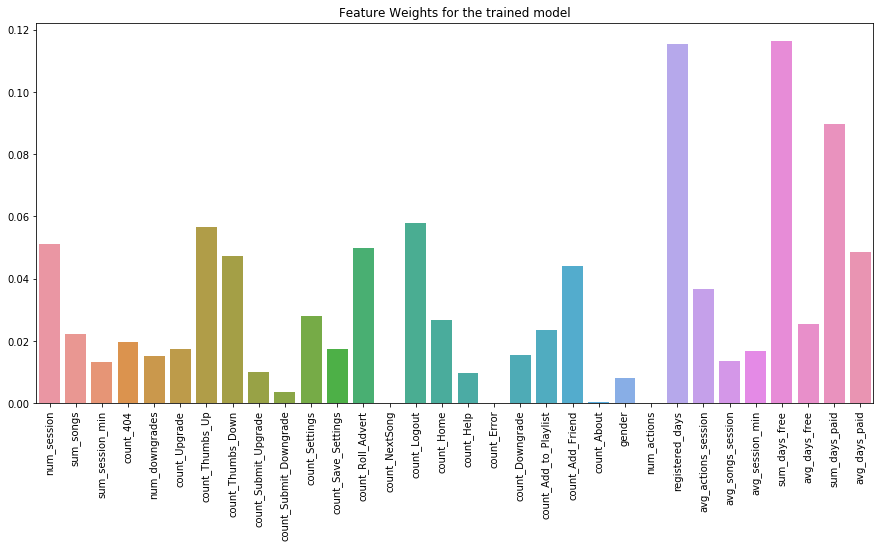

In [126]:
importance = list(bestModel.featureImportances.toArray())
plt.figure(figsize = [15,7])
sb.barplot(x=cols, y=importance).set_title('Feature Weights for the trained model');
plt.xticks(rotation=90);

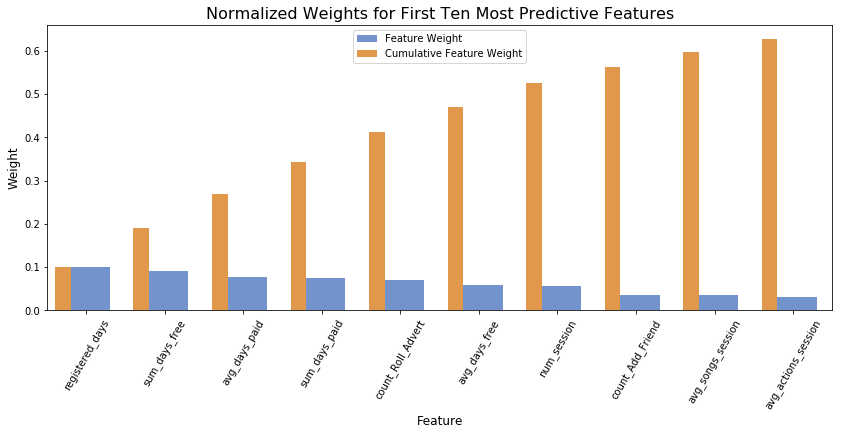

In [ ]:
feature_plot(importance, cols)

## Tuning DecisionTreeClassifier

In [149]:
model = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10, 20]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins,[5, 10]) \
    .build()
    

model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=42, parallelism=10)


start_time = time.time()
print('Start fitting..')
fitted_model = model_evaluator.fit(train)
duration = time.time()-start_time
print(f'Done in {str(datetime.timedelta(seconds=int(duration)))}')
bestModel = fitted_model.bestModel
print('Details:')
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('impurity - ', bestModel.getOrDefault('impurity'))
print('maxBins - ', bestModel.getOrDefault('maxBins'))

Start fitting..
Done in 0:01:01
Details:
maxDepth -  5
impurity -  entropy
maxBins -  5


In [150]:
model_eval(fitted_model, train)

Test Error = 0.132394
Accuracy = 0.867606
f1 = 0.858031
weightedPrecision = 0.861683
weightedRecall = 0.867606
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 36| 43|
|             0.0|265| 11|
+----------------+---+---+

None


In [151]:
model_eval(fitted_model, test)

Test Error = 0.182796
Accuracy = 0.817204
f1 = 0.811634
weightedPrecision = 0.808166
weightedRecall = 0.817204
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 10| 10|
|             0.0| 66|  7|
+----------------+---+---+

None


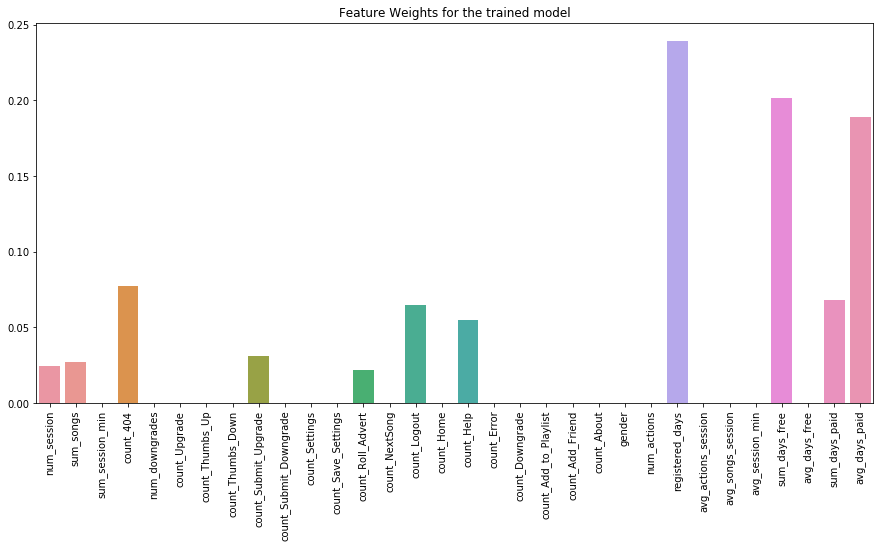

In [152]:
importance = list(bestModel.featureImportances.toArray())
plt.figure(figsize = [15,7])
sb.barplot(x=cols, y=importance).set_title('Feature Weights for the trained model');
plt.xticks(rotation=90);

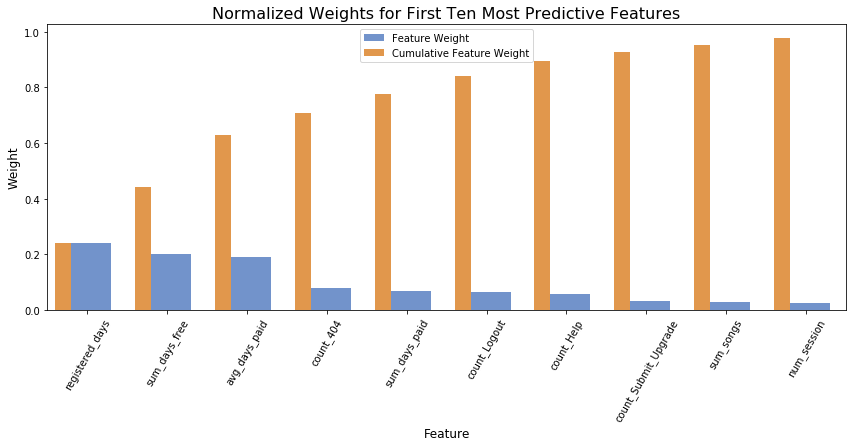

In [153]:
feature_plot(importance, cols)

In [ ]:
criterion = ['gini', 'entropy']
    max_depth = [4,6,8,12]

## Tuning GradientBoost

In [ ]:
model = GBTClassifier()
paramGrid = (ParamGridBuilder()
             .addGrid(model.maxDepth, [2, 4, 6])
             .addGrid(model.maxBins, [20, 60])
             .addGrid(model.maxIter, [10, 20])
             .build())

model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=42, parallelism=10)

start_time = time.time()
print('Start fitting..')
fitted_model = model_evaluator.fit(train)
duration = time.time()-start_time
print(f'Done in {str(datetime.timedelta(seconds=int(duration)))}')
bestModel = fitted_model.bestModel
print('Details:')
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('maxBins - ', bestModel.getOrDefault('maxBins'))
print('maxIter - ', bestModel.getOrDefault('maxIter'))

Start fitting..
Done in 0:57:03
Details:
maxDepth -  5
maxBins -  32
maxIter -  20


In [ ]:
model_eval(fitted_model, train)

Test Error = 0.0056338
Accuracy = 0.994366
f1 = 0.99434
weightedPrecision = 0.994407
weightedRecall = 0.994366
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  2| 77|
|             0.0|276|  0|
+----------------+---+---+

None


In [ ]:
model_eval(fitted_model, test)

Test Error = 0.16129
Accuracy = 0.83871
f1 = 0.846659
weightedPrecision = 0.864813
weightedRecall = 0.83871
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  4| 16|
|             0.0| 62| 11|
+----------------+---+---+

None


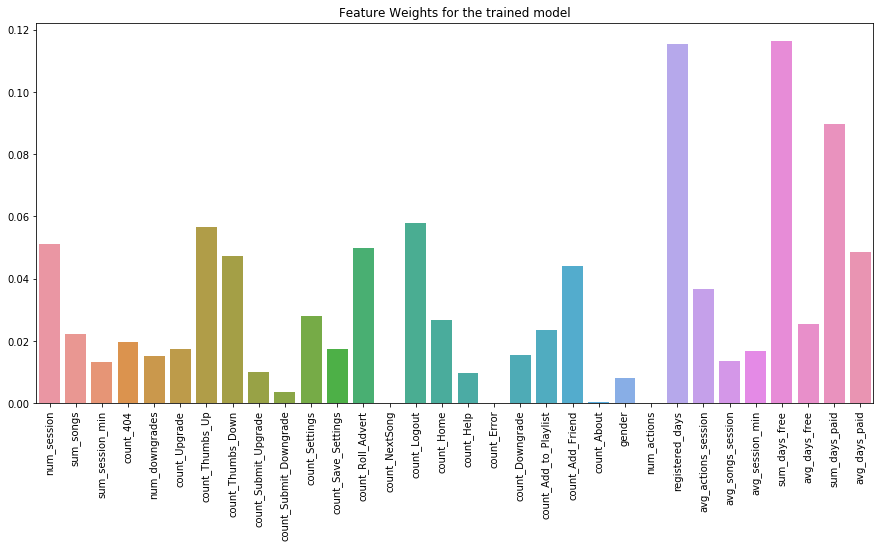

In [124]:
importance = list(fitted_model.bestModel.featureImportances.toArray())
plt.figure(figsize = [15,7])
sb.barplot(x=cols, y=importance).set_title('Feature Weights for the trained model');
plt.xticks(rotation=90);

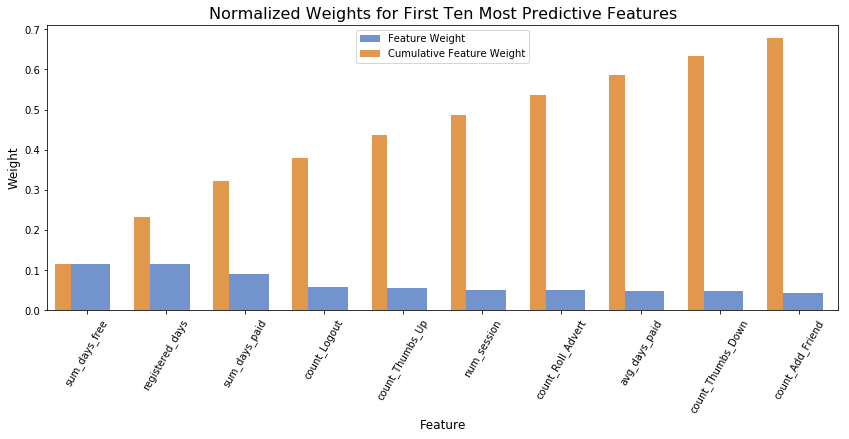

In [125]:
feature_plot(importance, cols)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.